In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/electricity-consumption/train.csv
/kaggle/input/electricity-consumption/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/electricity-consumption/train.csv')
test = pd.read_csv('/kaggle/input/electricity-consumption/test.csv')
test1 = pd.read_csv('/kaggle/input/electricity-consumption/test.csv')

In [3]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [4]:
train['datetime'] = pd.to_datetime(train.datetime,format='%Y-%m-%d %H:%M:%S') 
test['datetime'] = pd.to_datetime(test.datetime,format='%Y-%m-%d %H:%M:%S')

In [5]:
for i in (train, test):
    i['Year'] = i.datetime.dt.year
    i['Month'] = i.datetime.dt.month
    i['Day'] = i.datetime.dt.day
    i['Hour'] = i.datetime.dt.hour

In [6]:
train = train.drop(['ID','datetime'], axis=1)
test = test.drop(['ID','datetime'], axis=1)

In [7]:
train.head()

,temperature,var1,pressure,windspeed,var2,electricity_consumption,Year,Month,Day,Hour
0,-11.4,-17.1,1003.0,571.910,A,216.0,2013,7,1,0
1,-12.1,-19.3,996.0,575.040,A,210.0,2013,7,1,1
2,-12.9,-20.0,1000.0,578.435,A,225.0,2013,7,1,2
3,-11.4,-17.1,995.0,582.580,A,216.0,2013,7,1,3
4,-11.4,-19.3,1005.0,586.600,A,222.0,2013,7,1,4


In [8]:
train.shape, test.shape

((26496, 10), (8568, 9))

In [9]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train.shape, test.shape

((26496, 12), (8568, 11))

In [10]:
train['electricity_consumption'] = np.log(np.log(train['electricity_consumption']))
train['windspeed'] = np.log(train['windspeed'])
train['pressure'] = np.log(train['pressure'])

test['pressure'] = np.log(test['pressure'])
test['windspeed'] = np.log(test['windspeed'])

In [11]:
from sklearn.preprocessing import StandardScaler
cols = ['temperature', 'var1']
scaler = StandardScaler().fit(train[cols])

train[cols] = scaler.transform(train[cols])
test[cols] = scaler.transform(test[cols])
scaler.mean_

array([ 5.09898853, -1.91623264])

In [12]:
train.head()

,temperature,var1,pressure,windspeed,electricity_consumption,Year,Month,Day,Hour,var2_A,var2_B,var2_C
0,-1.900215,-1.456523,6.910751,6.348982,1.681810,2013,7,1,0,1,0,0
1,-1.980835,-1.667561,6.903747,6.354440,1.676556,2013,7,1,1,1,0,0
2,-2.072972,-1.734710,6.907755,6.360326,1.689376,2013,7,1,2,1,0,0
3,-1.900215,-1.456523,6.902743,6.367467,1.681810,2013,7,1,3,1,0,0
4,-1.900215,-1.667561,6.912743,6.374343,1.686895,2013,7,1,4,1,0,0


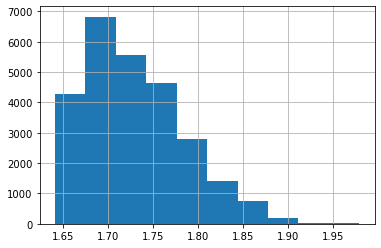

In [13]:
train['electricity_consumption'].hist()

In [14]:
from sklearn.model_selection import train_test_split
X = train.drop('electricity_consumption', axis=1)
y = train['electricity_consumption']

X_test = test.copy()

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Tree Modelling

In [15]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
model = LGBMRegressor(learning_rate=0.5, max_depth=5)
model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
model.score(x_train, y_train)

0.760135723179532

In [17]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(x_val)
np.sqrt(mean_squared_error(np.exp(np.exp(y_pred)), np.exp(np.exp(y_val))))

64.00429321468978

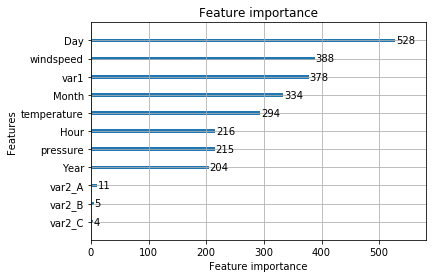

In [18]:
import lightgbm
lightgbm.plot_importance(model)

In [19]:
pred_test = model.predict(X_test)

In [20]:
err = []
y_pred_tot_lgm = []

from sklearn.model_selection import KFold

fold = KFold(n_splits=15, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMRegressor(max_depth=5, 
                      learning_rate=0.4)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='rmse',
          verbose=200)
    pred_y = m.predict(x_val)
    print("err_lgm: ",np.sqrt(mean_squared_error(np.exp(np.exp(pred_y)), np.exp(np.exp(y_val)))))
    err.append(np.sqrt(mean_squared_error(np.exp(np.exp(pred_y)), np.exp(np.exp(y_val)))))
    pred_test = m.predict(X_test)
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0271914	training's l2: 0.000739374	valid_1's rmse: 0.0312381	valid_1's l2: 0.000975818
err_lgm:  64.60585304827009
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0271154	training's l2: 0.000735247	valid_1's rmse: 0.0302775	valid_1's l2: 0.000916727
err_lgm:  59.72733800323218
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0270702	training's l2: 0.000732796	valid_1's rmse: 0.032615	valid_1's l2: 0.00106374
err_lgm:  68.3307866282813
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0271307	training's l2: 0.000736077	valid_1's rmse: 0.0298414	valid_1's l2: 0.000890511
err_lgm:  59.44194504927207
Tra

In [21]:
np.mean(err)

64.69346425834517

In [22]:
submission = pd.DataFrame()
submission['ID'] = test1['ID']
submission['electricity_consumption'] = np.exp(np.exp(np.mean(y_pred_tot_lgm, 0)))
submission.to_csv('LGB.csv', index=False)